In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class DualAgentMaze:
    def __init__(self, maze_size=(10, 10), start_nodes=None, goal_nodes=None):
        self.maze_size = maze_size
        self.width = int(self.maze_size[0])
        self.height = int(self.maze_size[1])
        self.maze_map = np.zeros((self.height, self.width), dtype='int')

        # Đặt các điểm bắt đầu cho hai tác nhân
        if start_nodes is None:
            self.start_nodes = [(0, 0), (0, self.width - 1)]  # Hai tác nhân ở hai góc trên
        else:
            self.start_nodes = start_nodes

        # Đặt các điểm mục tiêu (phần thưởng) ở vị trí khác nhau
        if goal_nodes is None:
            self.goal_nodes = [(self.height - 1, 0), (self.height - 1, self.width - 1)]  # Hai phần thưởng ở hai góc dưới
        else:
            self.goal_nodes = goal_nodes

        # Đặt tường cố định để tạo ra mê cung
        self.add_fixed_walls()

    def add_fixed_walls(self):
        """ Thêm các tường cố định vào mê cung để tạo ra độ khó cao hơn và loại bỏ tường cụ thể """
        # Tường được thêm vào để tạo ra các lối đi hẹp và hành lang
        walls = [
            # Tạo các bức tường để tạo thành lối đi
            (1, 1), (1, 2), (1, 4), (1, 5), (1, 7),
            (2, 3), (2, 7), (2, 8),
            (3, 1), (3, 5), (3, 6), (3, 8),
            (4, 0), (4, 3), (4, 7), (4, 9),
            (5, 2), (5, 5), (5, 6),
            (6, 1), (6, 4), (6, 8),
            (7, 3), (7, 7),
            (8, 2), (8, 6), (8, 9)
        ]

        # Loại bỏ tường cụ thể mà bạn yêu cầu
        walls_to_remove = [(6, 4)]  # Bức tường tại vị trí này sẽ được loại bỏ
        walls = [wall for wall in walls if wall not in walls_to_remove]

        for (i, j) in walls:
            self.maze_map[i, j] = 1  # Đánh dấu tường là 1

    def plot_maze(self, agents_positions=None, show=True):
        # Tạo bản sao của `maze_map` để không thay đổi bản gốc
        temp_maze_map = np.copy(self.maze_map)

        # Đặt các tác nhân tại vị trí hiện tại của chúng
        if agents_positions:
            for idx, pos in enumerate(agents_positions):
                i, j = pos
                temp_maze_map[i, j] = 2 + idx  # Đặt màu xanh dương cho Agent A và màu xanh lá cho Agent B

        # Đặt điểm mục tiêu
        for (i, j) in self.goal_nodes:
            temp_maze_map[i, j] = 4  # Đánh dấu mục tiêu chung là 4 (màu vàng)

        # Tạo màu sắc cho từng giá trị trong bản đồ mê cung
        color_map = {
            0: 'white',     # Đường đi
            1: 'black',     # Tường
            2: 'blue',      # Vị trí hiện tại của tác nhân A
            3: 'green',     # Vị trí hiện tại của tác nhân B
            4: 'yellow',    # Phần thưởng chung cho cả hai tác nhân
        }

        # Chuẩn bị bản đồ màu cho `matplotlib`
        img = np.zeros((temp_maze_map.shape[0], temp_maze_map.shape[1], 3))
        for (i, j), value in np.ndenumerate(temp_maze_map):
            img[i, j] = colors.to_rgb(color_map[value])

        # Hiển thị mê cung với kích thước vừa phải và tường sát với tác nhân
        plt.figure(figsize=(8, 8))
        plt.imshow(img, origin='lower')

        plt.xticks([])
        plt.yticks([])
        plt.grid(visible=False)  # Tắt lưới để chỉ tập trung vào các thành phần của mê cung

        if show:
            plt.show()

In [ ]:
# Lớp MonteCarloAgent sử dụng Monte Carlo và thuật toán hợp tác
class MonteCarloAgent:
    def __init__(self, name, start_position, goal_position, actions, agent_number, shared_q_table,
                 gamma=0.9, learning_rate=0.1, exploration_rate=1.0, exploration_decay=0.995, delta=0.1):
        self.name = name
        self.start_position = start_position
        self.position = start_position
        self.goal = goal_position
        self.actions = actions
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.delta = delta
        self.q_table = shared_q_table
        self.total_steps = 0
        self.agent_number = agent_number
        self.episode_memory = []  # Bộ nhớ để lưu tập (episode)

        # Thêm MaxStep để sử dụng trong các thao tác khác
        self.MaxStep = 1000
        self.tix = defaultdict(lambda: self.MaxStep)  # Lưu trữ tix_i cho mỗi mục tiêu x
        self.Tix = defaultdict(lambda: self.MaxStep)  # Lưu trữ Tix cho mỗi mục tiêu x
        self.internal_reward = 0  # Phần thưởng nội bộ

    def reset(self):
        """Khởi tạo lại trạng thái của tác nhân."""
        self.position = self.start_position
        self.total_steps = 0
        self.internal_reward = 0
        self.episode_memory = []

    def choose_action(self, possible_actions):
        """Chọn một hành động dựa trên chính sách epsilon-greedy."""
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(possible_actions)
        else:
            q_values = [self.q_table[(self.position, action)] for action in possible_actions]
            max_q = max(q_values)
            max_actions = [action for action, q in zip(possible_actions, q_values) if q == max_q]
            return random.choice(max_actions)

    def update_q_value(self):
        """Cập nhật giá trị Q dựa trên phương pháp Monte Carlo."""
        G = 0
        for state, action, reward in reversed(self.episode_memory):
            G = self.gamma * G + reward
            current_q = self.q_table[(state, action)]
            self.q_table[(state, action)] += self.learning_rate * (G - current_q)

    def decay_exploration(self):
        """Giảm tỷ lệ khám phá."""
        self.exploration_rate *= self.exploration_decay

    def record_step(self, state, action, reward):
        """Ghi lại một bước trong tập."""
        self.episode_memory.append((state, action, reward))

    def estimate_internal_reward(self):
        """Tính toán phần thưởng nội bộ dựa trên công thức."""
        tAL = self.tix[self.goal]
        tAS = self.Tix[self.goal]
        gamma = self.gamma
        delta = self.delta
        if tAL - tAS > 0:
            ir = (gamma ** (tAL - tAS)) * self.internal_reward + delta
        else:
            ir = self.internal_reward
        self.internal_reward = ir

    def share_tix(self, agents):
        """Chia sẻ tix_i với các tác nhân khác."""
        for agent in agents:
            if agent != self:
                if self.goal in agent.tix:
                    agent.tix[self.goal] = min(agent.tix[self.goal], self.tix[self.goal])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import time

# Hàm huấn luyện các tác nhân với thuật toán Monte Carlo và thu thập tổng phần thưởng, thời gian
def train_agents(env, episodes=1000):
    rewards_history = {agent.name: [] for agent in env.agents}  # Lưu lịch sử phần thưởng cho mỗi tập
    steps_history = []  # Lưu trữ số bước mỗi tập
    total_time = 0  # Tổng thời gian huấn luyện

    for episode in range(1, episodes + 1):
        env.reset()
        done = [False, False]
        steps = 0
        episode_rewards = {agent.name: 0 for agent in env.agents}

        start_time = time.time()  # Bắt đầu đếm thời gian cho tập này

        for agent in env.agents:
            agent.decay_exploration()  # Giảm tỷ lệ khám phá

        while not all(done):  # Không còn giới hạn số bước tối đa mỗi tập
            steps += 1
            for idx, agent in enumerate(env.agents):
                if not done[idx]:
                    state = agent.position
                    action = agent.choose_action(env.get_possible_actions(agent))
                    next_state, reward, done[idx] = env.step(idx, action)

                    # Ghi nhận bước đi và phần thưởng
                    agent.record_step(state, action, reward)

                    episode_rewards[agent.name] += reward

                    if done[idx]:
                        agent.Tix[agent.goal] = steps

            # Sau mỗi bước, các tác nhân chia sẻ tix_i
            for agent in env.agents:
                goal = agent.goal
                Tix = agent.Tix[goal]
                if Tix < agent.tix[goal]:
                    agent.tix[goal] = Tix
                    agent.share_tix(env.agents)

        end_time = time.time()  # Kết thúc đếm thời gian cho tập này
        elapsed_time = end_time - start_time  # Thời gian đã trôi qua cho tập này
        total_time += elapsed_time  # Cộng dồn tổng thời gian huấn luyện

        # Sau khi hoàn thành tập, cập nhật Q-value bằng Monte Carlo
        for agent in env.agents:
            agent.update_q_value()  # Cập nhật Q-value cho toàn bộ tập

        # Ghi nhận phần thưởng của mỗi tác nhân sau mỗi tập
        for agent in env.agents:
            rewards_history[agent.name].append(episode_rewards[agent.name])

        steps_history.append(steps)

        if episode > 0:
            print(f"Tập {episode}/{episodes} - Tổng phần thưởng:")
            table = []
            for agent in env.agents:
                total_reward = sum(rewards_history[agent.name])  # Tổng phần thưởng đến hiện tại
                table.append([agent.name, round(total_reward, 4)])
            print(tabulate(table, headers=["Agent", "Total Reward"], tablefmt="pretty"))
            print(f"Số bước trung bình mỗi tập: {np.mean(steps_history):.2f}")
            print(f"Tổng thời gian huấn luyện: {total_time:.4f} giây")
            print("-" * 80)

    print("Huấn luyện hoàn tất.")
    return rewards_history, total_time, steps_history


In [ ]:
class MazeEnv:
    def __init__(self, maze):
        self.maze = maze
        # Các hành động: lên, xuống, trái, phải
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        shared_q_table = defaultdict(float)

        # Khởi tạo các tác nhân Monte Carlo
        self.agent_A = MonteCarloAgent(
            "Agent A",
            maze.start_nodes[0],
            maze.goal_nodes[0],
            self.actions,
            agent_number=2,
            shared_q_table=shared_q_table
        )
        self.agent_B = MonteCarloAgent(
            "Agent B",
            maze.start_nodes[1],
            maze.goal_nodes[1],
            self.actions,
            agent_number=2,
            shared_q_table=shared_q_table
        )
        self.agents = [self.agent_A, self.agent_B]
        self.goals_reached = [False, False]

    def reset(self):
        for agent in self.agents:
            agent.reset()
        self.goals_reached = [False, False]
        return [agent.position for agent in self.agents]

    def get_possible_actions(self, agent):
        """Trả về danh sách các hành động hợp lệ dựa trên vị trí của tác nhân."""
        x, y = agent.position
        possible_actions = []
        for dx, dy in self.actions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.maze.height and 0 <= ny < self.maze.width:
                if self.maze.maze_map[nx, ny] != 1:  # Không phải tường
                    possible_actions.append((dx, dy))
        return possible_actions

    def step(self, agent_idx, action):
        agent = self.agents[agent_idx]
        possible_actions = self.get_possible_actions(agent)
        reward = -0.1  # Phạt cho mỗi bước đi

        if action in possible_actions:
            new_position = (agent.position[0] + action[0], agent.position[1] + action[1])
            agent.position = new_position
            agent.total_steps += 1
        else:
            reward = -1  # Phạt nặng cho hành động không hợp lệ

        done = False
        if agent.position == agent.goal and not self.goals_reached[agent_idx]:
            reward = 1  # Phần thưởng khi đến đích
            done = True
            self.goals_reached[agent_idx] = True

            # Cập nhật Tix
            agent.Tix[agent.goal] = agent.total_steps

        return agent.position, reward, done




Tập 100/1000 - Tổng phần thưởng:
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -2594.6    |
| Agent B |   -3168.8    |
+---------+--------------+
Số bước trung bình mỗi tập: 449.58
Tổng thời gian huấn luyện: 0.5027 giây
--------------------------------------------------------------------------------
Tập 200/1000 - Tổng phần thưởng:
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -10502.4   |
| Agent B |   -5321.0    |
+---------+--------------+
Số bước trung bình mỗi tập: 706.16
Tổng thời gian huấn luyện: 4.9504 giây
--------------------------------------------------------------------------------
Tập 300/1000 - Tổng phần thưởng:
+---------+--------------+
|  Agent  | Total Reward |
+---------+--------------+
| Agent A |   -11463.6   |
| Agent B |   -5781.0    |
+---------+--------------+
Số bước trung bình mỗi tập: 517.99
Tổng thời gian huấn luyện: 5.1907 giây
-------------------------------

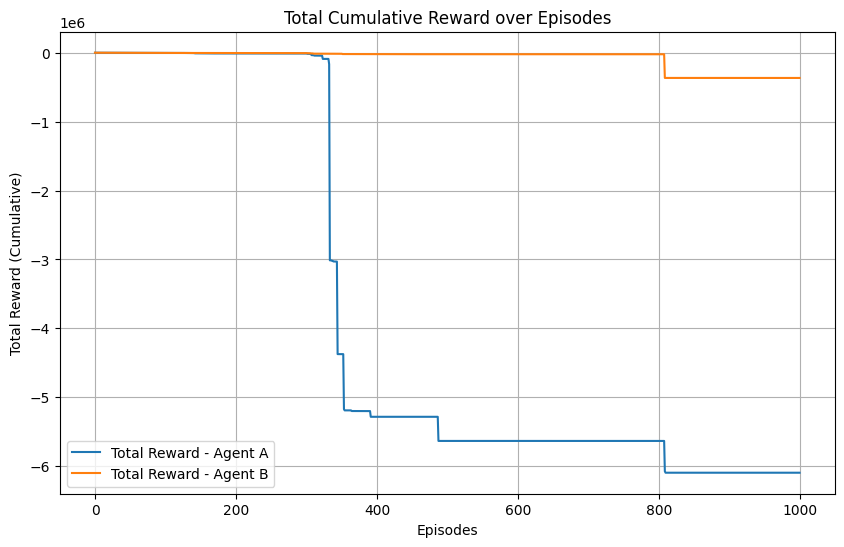

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import time

# Hàm huấn luyện các tác nhân với thuật toán Monte Carlo và thu thập tổng phần thưởng, thời gian
def train_agents(env, episodes=1000):
    for agent in env.agents:
        agent.tix[agent.goal] = agent.MaxStep

    rewards_history = {agent.name: [] for agent in env.agents}  # Lưu lịch sử phần thưởng cho mỗi tập
    steps_history = []  # Lưu trữ số bước mỗi tập
    total_time = 0  # Tổng thời gian huấn luyện

    for episode in range(1, episodes + 1):
        env.reset()
        done = [False, False]
        steps = 0
        episode_rewards = {agent.name: 0 for agent in env.agents}

        start_time = time.time()  # Bắt đầu đếm thời gian cho tập này

        for agent in env.agents:
            agent.decay_exploration()  # Giảm tỷ lệ khám phá

        while not all(done):  # Không giới hạn số bước
            steps += 1
            for idx, agent in enumerate(env.agents):
                if not done[idx]:
                    state = agent.position
                    action = agent.choose_action(env.get_possible_actions(agent))
                    next_state, reward, done[idx] = env.step(idx, action)

                    # Ghi nhận bước đi và phần thưởng
                    agent.record_step(state, action, reward)

                    episode_rewards[agent.name] += reward

                    if done[idx]:
                        agent.Tix[agent.goal] = steps

            # Sau mỗi bước, các tác nhân chia sẻ tix_i
            for agent in env.agents:
                goal = agent.goal
                Tix = agent.Tix[goal]
                if Tix < agent.tix[goal]:
                    agent.tix[goal] = Tix
                    agent.share_tix(env.agents)

        end_time = time.time()  # Kết thúc đếm thời gian cho tập này
        elapsed_time = end_time - start_time  # Thời gian đã trôi qua cho tập này
        total_time += elapsed_time  # Cộng dồn tổng thời gian huấn luyện

        # Sau khi hoàn thành tập, cập nhật Q-value bằng Monte Carlo
        for agent in env.agents:
            agent.update_q_value()  # Cập nhật Q-value cho toàn bộ tập

        # Ghi nhận phần thưởng của mỗi tác nhân sau mỗi tập
        for agent in env.agents:
            rewards_history[agent.name].append(episode_rewards[agent.name])

        steps_history.append(steps)

        if episode % 100 == 0:
            print(f"Tập {episode}/{episodes} - Tổng phần thưởng:")
            table = []
            for agent in env.agents:
                total_reward = sum(rewards_history[agent.name])  # Tổng phần thưởng đến hiện tại
                table.append([agent.name, round(total_reward, 4)])
            print(tabulate(table, headers=["Agent", "Total Reward"], tablefmt="pretty"))
            print(f"Số bước trung bình mỗi tập: {np.mean(steps_history):.2f}")
            print(f"Tổng thời gian huấn luyện: {total_time:.4f} giây")
            print("-" * 80)

    print("Huấn luyện hoàn tất.")

    # Sau khi hoàn thành huấn luyện, in ra tổng thời gian huấn luyện
    print(f"Tổng thời gian huấn luyện: {total_time:.4f} giây")
    return rewards_history, total_time, steps_history

# Hàm vẽ biểu đồ tổng phần thưởng
def plot_total_rewards(rewards_history):
    plt.figure(figsize=(10, 6))

    for agent_name, rewards in rewards_history.items():
        # Tính tổng phần thưởng tích lũy theo thời gian
        cumulative_rewards = np.cumsum(rewards)
        plt.plot(cumulative_rewards, label=f'Total Reward - {agent_name}')

    plt.xlabel('Episodes')
    plt.ylabel('Total Reward (Cumulative)')
    plt.title('Total Cumulative Reward over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Giả sử đã có các đối tượng môi trường và tác nhân, gọi hàm để train và vẽ biểu đồ
if __name__ == "__main__":
    # Khởi tạo đối tượng `DualAgentMaze`
    maze = DualAgentMaze(maze_size=(10, 10))
    env = MazeEnv(maze)

    # Huấn luyện các tác nhân và thu thập lịch sử phần thưởng và thời gian
    rewards_history, total_time, steps_history = train_agents(
        env, episodes=1000
    )

    # Vẽ biểu đồ tổng phần thưởng
    plot_total_rewards(rewards_history)


In [ ]:
# Giả sử env đã được khởi tạo và mô hình đã được huấn luyện
save_model(env, 'trained_model.pkl')



Model saved to trained_model.pkl
